In [2]:
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore", category=RuntimeWarning)

data = pd.read_csv("/kaggle/input/shashlyck/resulted.csv")

data["msp_category"] = data["msp_category"].fillna("НЕ УКАЗАНО")
le_msp = LabelEncoder()
data["msp_category"] = le_msp.fit_transform(data["msp_category"])

data["main_okved"] = data["main_okved"].fillna("НЕ УКАЗАНО")
le_okved = LabelEncoder()
data["main_okved"] = le_okved.fit_transform(data["main_okved"])

for col in [
    "contracts_count_y", "contracts_sum_y", "contracts_mean_y",
    "unique_customers_y", "unique_regions_y"
]:
    data[col] = data[col].fillna(0)

date_cols = [
    "first_contract_date_y",
    "last_contract_date_y",
    "last_enforcement_date",
    "fetched_at"
]

for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors="coerce")
    med = data[col].median()
    data[col] = data[col].fillna(med)
    data[col] = data[col].astype("int64") // 10**9

years = list(range(2012, 2025))
report_cols = [f"report_{y}" for y in years if f"report_{y}" in data]
prior_cols  = [f"prior_{y}"  for y in years if f"prior_{y}"  in data]

data[report_cols] = data[report_cols].interpolate(
    method="linear", axis=1, limit_direction="both"
)
data[prior_cols] = data[prior_cols].interpolate(
    method="linear", axis=1, limit_direction="both"
)

arb_cols = [
    "arb_cases_cnt", "arb_cases_sum_total", "arb_cases_sum_max",
    "arb_cases_sum_min", "arb_cases_sum_mean", "arb_cases_lose_cnt",
    "arb_cases_win_cnt", "arb_cases_in_process_cnt", "arb_cases_last_year"
]
data[arb_cols] = data[arb_cols].fillna(0)

print("Дата-поля (int64):")
print(data[date_cols].dtypes)
print(data[date_cols].head())

print("\nКатегориальные после энкодинга:")
print("msp_category classes:", le_msp.classes_)
print("main_okved classes:", le_okved.classes_)


Дата-поля (int64):
first_contract_date_y    int64
last_contract_date_y     int64
last_enforcement_date    int64
fetched_at               int64
dtype: object
   first_contract_date_y  last_contract_date_y  last_enforcement_date  \
0             1354492800            1590019200             1741564800   
1             1298246400            1554422400             1744329600   
2             1440676800            1588809600             1743465600   
3             1297123200            1744243200             1741564800   
4             1293840000            1744156800             1741564800   

   fetched_at  
0  1745240571  
1  1745240571  
2  1745240571  
3  1745240571  
4  1745240571  

Категориальные после энкодинга:
msp_category classes: ['МАЛОЕ ПРЕДПРИЯТИЕ' 'МИКРОПРЕДПРИЯТИЕ' 'НЕ УКАЗАНО' 'СРЕДНЕЕ ПРЕДПРИЯТИЕ']
main_okved classes: ['02.1' '02.10' '02.20' '02.40' '02.40.2' '10.1' '10.11' '10.11.1'
 '10.11.3' '10.12' '10.12.1' '10.13' '10.13.1' '10.13.2' '10.13.3'
 '10.13.4' '10.13.6' '1

In [3]:
from sklearn.model_selection import train_test_split

df_targets  = pd.read_csv('/kaggle/input/matmod-it-psb/target_train.csv')

df = data.merge(df_targets[['inn', 'target']], on='inn', how='inner')

train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42,  
    stratify=df['target'] if 'target' in df.columns else None  
)

print(f'Train shape: {train_df.shape}')
print(f'Validation shape: {val_df.shape}')
print('\nTrain sample:')
print(train_df.head())
print('\nValidation sample:')
print(val_df.head())

Train shape: (8400, 62)
Validation shape: (2100, 62)

Train sample:
        id         inn  fetched_at  num_employees  msp_category  \
2644  3747  4029023921  1745240854             86             0   
5158  7355  6168031585  1745241126              3             0   
5331  7605  6318126020  1745241145              6             2   
1219  1686  2502056770  1745240698              0             0   
3970  5641  5259084350  1745240997             22             0   

      company_age_years  main_okved  main_okved2  num_founders  \
2644                 24         135           17             0   
5158                 15         509           46             1   
5331                 22         537           46             1   
1219                  8         270           25             1   
3970                 15         659           46             1   

      has_mass_founder  ...  arb_cases_cnt  arb_cases_sum_total  \
2644                 0  ...           14.0          39998611.82  

In [4]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

X_train = train_df.drop(['inn', 'target'], axis=1)
y_train = train_df['target']
X_val   = val_df.drop(['inn', 'target'], axis=1)
y_val   = val_df['target']

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

model.fit(
    X_train, 
    y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

y_pred_proba = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)
gini = 2 * auc - 1

print(f'AUC ROC       : {auc:.4f}')
print(f'Gini (2·AUC-1) : {gini:.4f}')

0:	test: 0.7809834	best: 0.7809834 (0)	total: 69.3ms	remaining: 1m 9s
100:	test: 0.8818468	best: 0.8820697 (96)	total: 1.13s	remaining: 10s
200:	test: 0.8912883	best: 0.8912883 (200)	total: 2.09s	remaining: 8.31s
300:	test: 0.8961884	best: 0.8963217 (299)	total: 3.12s	remaining: 7.24s
400:	test: 0.8973996	best: 0.8980870 (372)	total: 4.08s	remaining: 6.09s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.898087029
bestIteration = 372

Shrink model to first 373 iterations.
AUC ROC       : 0.8981
Gini (2·AUC-1) : 0.7962


In [5]:
import pandas as pd

df_test_ids = pd.read_csv('/kaggle/input/matmod-it-psb/target_test.csv')

test_df = data.merge(df_test_ids[['inn']], on='inn', how='inner')

X_test = test_df.drop(['inn'], axis=1)
y_test_proba = model.predict_proba(X_test)[:, 1]

threshold = 0.05
y_test_pred = (y_test_proba >= threshold).astype(int)

submission = pd.DataFrame({
    'inn': test_df['inn'],
    'prediction': y_test_pred
})

submission.to_csv('submission.csv', index=False)

print(f'Используемый порог: {threshold}')
print(submission.head())


Используемый порог: 0.05
          inn  prediction
0  1001001390           1
1  1001098784           1
2  1001174611           1
3  1001229243           1
4  1001240511           1


In [6]:
import pandas as pd

feature_names = X_train.columns.tolist()
importances = model.get_feature_importance(type='FeatureImportance')

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

total_imp = feat_imp_df['importance'].sum()
feat_imp_df['importance_rel'] = feat_imp_df['importance'] / total_imp

feat_imp_df = feat_imp_df.sort_values(
    by='importance_rel',
    ascending=False
).reset_index(drop=True)

feat_imp_df = feat_imp_df[['feature', 'importance_rel']]

print(feat_imp_df)


                     feature  importance_rel
0                report_2024        0.150138
1               msp_category        0.123367
2              num_employees        0.080687
3                 main_okved        0.042497
4                 prior_2024        0.031374
5        arb_cases_sum_total        0.031164
6                report_2023        0.027534
7       enforcement_debt_sum        0.023354
8                         id        0.022521
9                 prior_2023        0.021864
10               report_2022        0.021801
11                prior_2022        0.020848
12         arb_cases_sum_max        0.018366
13              num_founders        0.017304
14      last_contract_date_y        0.016614
15      enforcement_debt_max        0.016186
16     first_contract_date_y        0.015673
17               report_2021        0.013979
18   enforcement_debt_remain        0.013094
19                prior_2019        0.011603
20                prior_2021        0.011208
21        

SHAP array shape: (1000, 60)


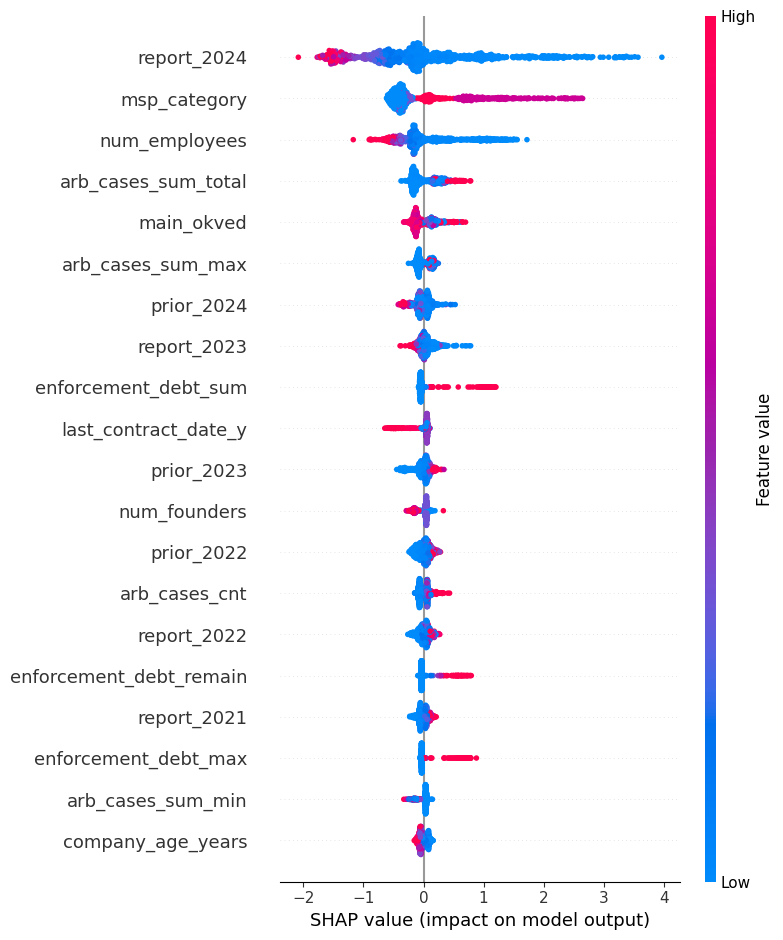

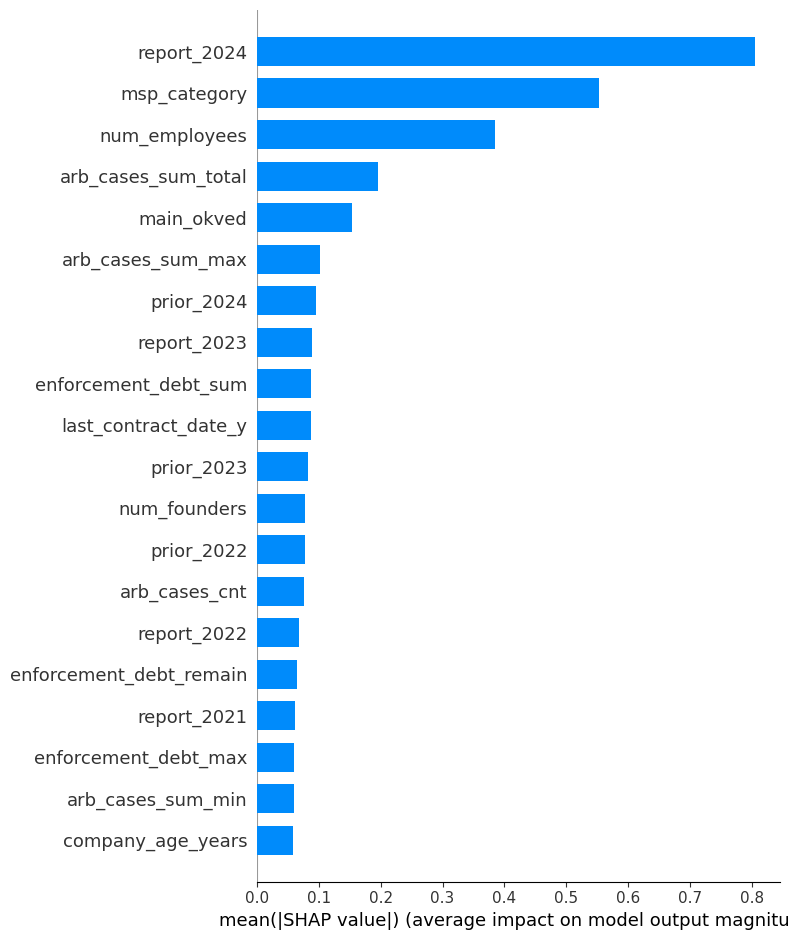

<Figure size 640x480 with 0 Axes>

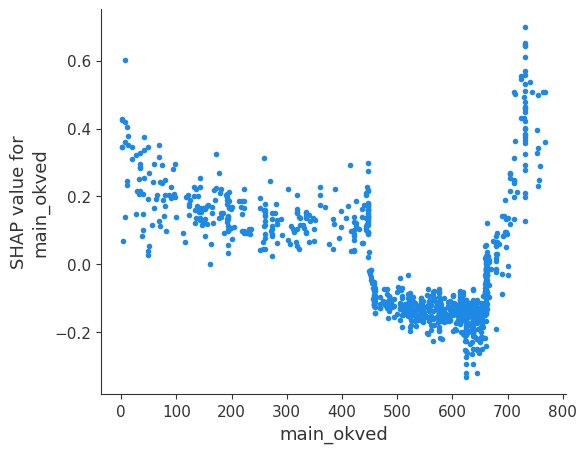

<Figure size 640x480 with 0 Axes>

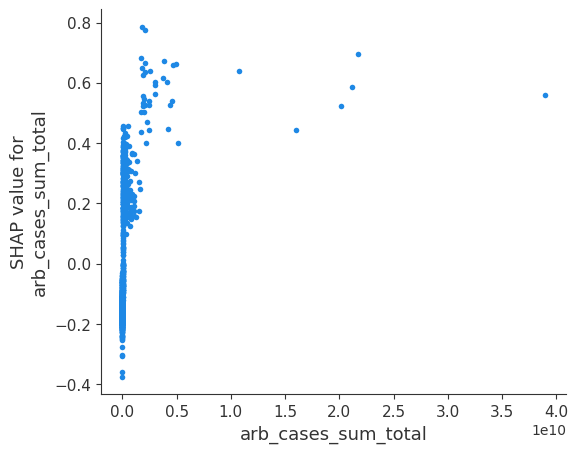

<Figure size 640x480 with 0 Axes>

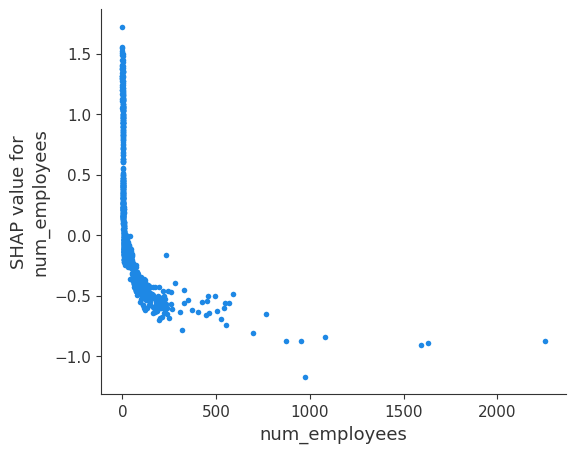

<Figure size 640x480 with 0 Axes>

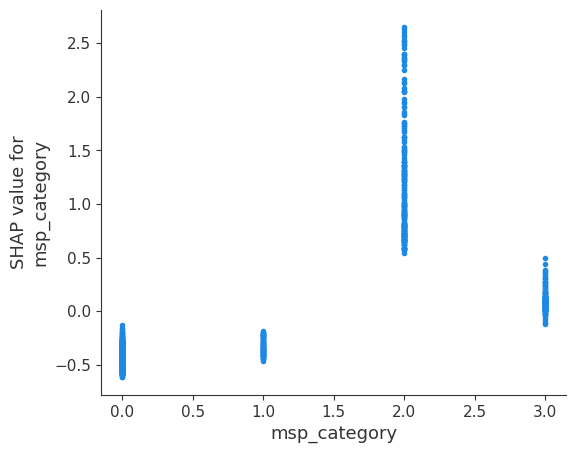

<Figure size 640x480 with 0 Axes>

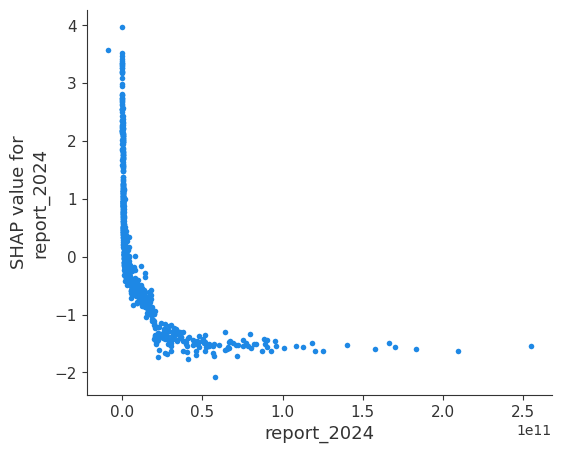

<Figure size 640x480 with 0 Axes>

In [10]:
import shap, numpy as np, matplotlib.pyplot as plt

# 1) Подвыборка с тем же списком колонок, что и при fit
X_sample = X_val.sample(1000, random_state=42)

# 2) Вычисляем shap-значения
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_sample)

# 3) Получаем нужный массив (n_samples, n_features)
if isinstance(shap_vals, list):
    shap_vals_full = shap_vals[1]
else:
    shap_vals_full = shap_vals

print("SHAP array shape:", shap_vals_full.shape)  # должно быть (1000, 62)

# 4) Отбрасываем id из визуализации
id_idx      = X_sample.columns.get_loc('id')
features_df = X_sample.drop('id', axis=1)
shap_for_plot = np.delete(shap_vals_full, id_idx, axis=1)

# 5) Глобальные графики
shap.summary_plot(shap_for_plot, features_df, plot_type="dot");  plt.tight_layout()
shap.summary_plot(shap_for_plot, features_df, plot_type="bar");  plt.tight_layout()

# 6) Dependence для топ-5
mean_abs = np.abs(shap_for_plot).mean(axis=0)
top5_i = np.argsort(mean_abs)[-5:]
for i in top5_i:
    feat = features_df.columns[i]
    shap.dependence_plot(feat, shap_for_plot, features_df, interaction_index=None)
    plt.tight_layout()

# 7) Локальная интерпретация (force, waterfall и т.д.) — аналогично прежнему примеру
